In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from aeon.transformations.collection.feature_based import TSFreshFeatureExtractor, Catch22
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifierCV

""" Recommended Versions
    pandas==1.5.3
    numpy==1.24.4
    tsfresh==0.20.3
    sklearn==1.0.2
    aeon==0.8.1

"""

' Recommended Versions\n    pandas==1.5.3\n    numpy==1.24.4\n    tsfresh==0.20.3\n    sklearn==1.0.2\n    aeon==0.8.1\n\n'

# 1. Base Function

### (1) Hard Voting

In [3]:
def hard_voting(testYList):
    """
    The predicted labels are obtained by hard voting to process the labels matrix
    from multiple classifiers.

    Parameters
    ----------
    testYList : 2D np.ndarray of shape = [n_classifierss, n_cases]
    """
    uniqueY = np.unique(testYList)  # Holds the label for each class
    n_classes = len(uniqueY)  # Number of classes
    n_classifiers, n_cases= testYList.shape[:]  # Number of classifiers, Number of cases
    testVY = np.zeros(n_cases, int)  # 1 * n_cases, Initializing the predicted labels
   
    testWeightArray = np.zeros((n_classes, n_cases))  # n_classes * n_cases, Label weight matrix for samples
    for i in range(n_cases):
        for j in range(n_classifiers):
            label_ = testYList[j, i]
            index_ = np.arange(n_classes)[uniqueY==label_]
            testWeightArray[index_, i] += 1  # The label weight for the sample is + 1 
    for i in range(n_cases):  # Predicting each sample label
        testVY[i] = uniqueY[np.argmax(testWeightArray[:, i])]  # The label is predicted to be the most weighted
    return testVY  # return the predicted labels

### (2) Tracking Differentiator

In [4]:
def fhan(x1, x2, r, h0):
    """
    The fhan function for calculating differential signal based on optimal 
    control in tracking differentiator.

    Parameters
    ----------
    x1 : float
        State 1 of the observer.
    x2 : float
        State 2 of the observer.
    r: float
        Velocity factor used to control tracking speed.
    h0 : float
        Step size.
    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """
    
    d = r * h0
    d0 = d * h0
    y = x1 + h0 * x2    # Computing the differential signal
    a0 = np.sqrt(d*d + 8*r*np.abs(y))

    if np.abs(y) > d0:
        a = x2 + (a0-d) / 2.0 * np.sign(y)
    else:
        a = x2 + y/h0

    if np.abs(a) <= d:  # Computing the input u of observer
        u = -r * a / d
    else:
        u = -r * np.sign(a)

    return u, y # Return input u of observer, and differential signal y


def td(signal, r=100, k=3, h=1):
    """
    The tracking differentiator with a adjustable filter factor to 
    compute a differential signal

    Parameters
    ----------
    signal : 1D np.ndarray of shape = [n_timepoints] 
        Original time series
    r : float
        Velocity factor used to control tracking speed.
    k: float
        filter factor.
    h : float
        Step size.
    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """
    x1 = signal[0]   # Initializing state 1
    x2 = -(signal[1] - signal[0]) / h   # Initializing state 2

    h0 = k * h
    signalTD = np.zeros(len(signal))
    dSignal = np.zeros(len(signal))
    for i in range(len(signal)):
        v = signal[i]
        x1k = x1    
        x2k = x2    
        x1 = x1k + h*x2k  # Update state 1
        u, y = fhan(x1k-v, x2k, r, h0)   # Update input u of observer and differential signal y
        x2 = x2k + h * u  # Update state 2
        dSignal[i] = y 
        signalTD[i] = x1 
    dSignal = -dSignal / h0  # Scale transform

    return dSignal[1:]  # Return the differential signal

### Example of a Tracking Differentiator

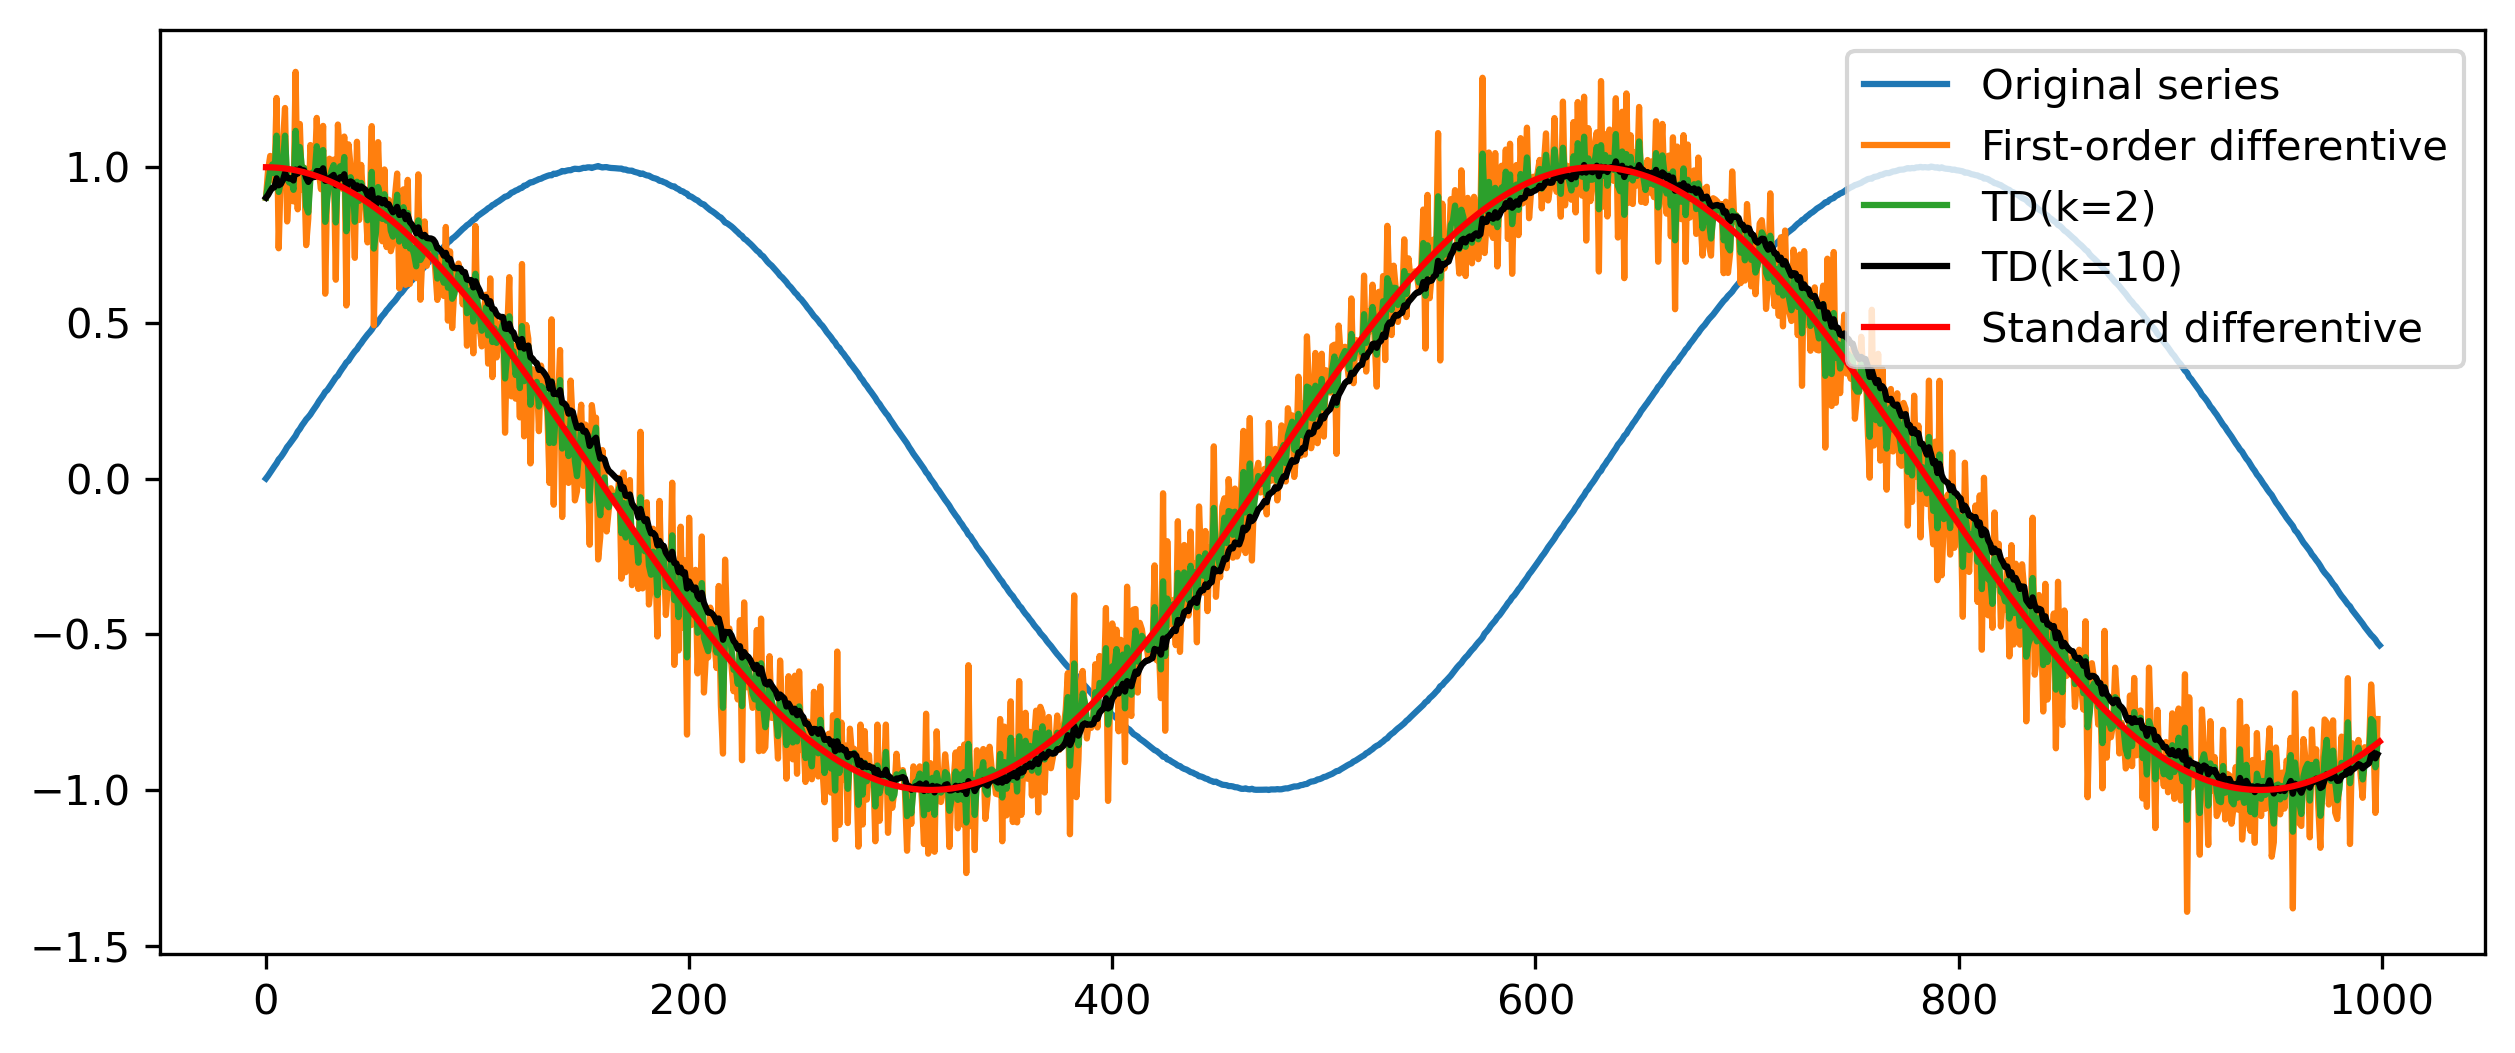

In [5]:
x = np.sin(np.arange(1000)/100) + np.random.randn(1000)/ 1000
y = np.cos(np.arange(1000)/100)

y0 = np.diff(x) * 100
y1 = td(x, k=2, h=1/100)
y2 = td(x, k=10, h=1/100)

plt.figure(figsize=(10, 4), dpi=300)
plt.plot(x, label="Original series")
plt.plot(y0, label="First-order differentive")
plt.plot(y1, label="TD(k=2)")
plt.plot(y2, label="TD(k=10)", c="k")
plt.plot(y, label="Standard differentive", c="r")
plt.legend()
plt.show()

### (3) Series Transform

In [6]:
def series_transform(seriesX, k1=3):
    """
    Each series of the time series set is transformed by tracking differentiator with 
    a adjustable filter factor to output the differential time series set.

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    k1 : float, default=2
        filter factor 1 of the tracking differentiator 1.

    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """

    n_cases, n_channels, n_timepoints = seriesX.shape[:]

    seriesFX = np.zeros((n_cases, n_channels, n_timepoints-1))
    for i in range(n_cases):
        for j in range(n_channels):
            seriesFX[i, j, :] = td(seriesX[i, j, :], k=k1)
            seriesFX[i, j, :] = scale(seriesFX[i, j, :])
    return seriesFX  # Return the first-order differential time series set

### (4) Bidirectional Dilation Mapping

In [7]:
def bidirect_dilation_mapping(seriesX, max_rate=16):
    """
    According to the series length, obtain a list of series indices that are bidirectionally 
    dilated under the exponential shuffling rates.

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    max_rate : int, default=16
        Maximum shuffling rate
    """    
    
    n_cases, n_channels, n_timepoints = seriesX.shape[0], seriesX.shape[1], seriesX.shape[2]
    max_power = np.min([int(np.log2(max_rate)), int(np.log2(n_timepoints-1))-3])
    max_power = np.max([1, max_power])  # Guaranteed to be positive
    dilation_rates = 2**np.arange(1, max_power+1)  # Shuffling rates
    
    indexList0 = np.arange(n_timepoints)  # The index of the raw series
    indexListF = []  # Initialize the index list for forward dilation
    indexListB = []  # Initialize the index list for backward dilation
    for i in range(len(dilation_rates)):  # Perform dilation at each shuffling rate
        rate_ = dilation_rates[i]  # shuffling rate
        # (1) Forward dilation mapping
        index_ = np.array([])
        for j in range(rate_):  # Rearrange index
            index_ = np.concatenate((index_, indexList0[j::rate_])).astype(int)
        indexListF.append(index_)
        # (2) Backward dilation mapping 
        index_ = np.array([])
        for j in range(rate_):  # Rearrange index
            index_ = np.concatenate((indexList0[j::rate_], index_)).astype(int)
        indexListB.append(index_)
    
    indexList = np.vstack((indexListF, indexListB))
    
    return indexList

### (5)  Bidirectional Interleaving Mapping

In [8]:
def bidirect_interleaving_mapping(seriesX, max_rate=16):
    """
    According to the series length, obtain a list of series indices that are bidirectionally 
    interleaved under the exponential shuffling rates.

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    max_rate : int, default=16
        Maximum shuffling rate。
    """   
    
    n_cases, n_channels, n_timepoints = seriesX.shape[0], seriesX.shape[1], seriesX.shape[2]
    max_power = np.min([int(np.log2(max_rate)), int(np.log2(n_timepoints-1))-3]) 
    max_power = np.max([1, max_power])  # Guaranteed to be positive
    dilation_rates = 2**np.arange(1, max_power+1)  # Shuffling rates
    
    indexList0 = np.arange(n_timepoints)  # The index of the raw series
    indexListF = []  # Initialize the index list for forward interleaving
    indexListB = []  # Initialize the index list for backward interleaving
    for i in range(len(dilation_rates)):  # Perform interleaving at each shuffling rate
        rate_ = dilation_rates[i]  # shuffling rate
        index_ = np.array([])
        segmentNs = np.zeros(rate_, int)
        segmentIndex = []
        start = 0
        for j in range(rate_):  # Get the length and index of each segment
            segmentNs[j] = len(indexList0[j::rate_])
            segmentIndex.append(np.arange(start, start+segmentNs[j]))
            start += segmentNs[j]
        # (1) Forward interleaving mapping
        index_ = np.array([])
        for j in range(len(segmentIndex[0])):  # Rearrange index
            for k in range(rate_):  # Take a point from each segment
                index_ = np.concatenate((index_, [segmentIndex[k][j]])).astype(int)
                if len(index_) == len(indexList0):
                    break
            if len(index_) == len(indexList0):
                break
        indexListF.append(index_)
        
        # (2) Backward interleaving mapping 
        index_ = np.array([])
        segmentNs = segmentNs[::-1]
        segmentIndex = []
        start = 0
        for j in range(rate_):  # Get the length and index of each segment
            segmentIndex.append(np.arange(start, start+segmentNs[j]))
            start += segmentNs[j]
        
        for j in range(len(segmentIndex[-1])):  # Rearrange index
            for k in range(rate_):  # Take a point from each segment
                if np.abs(j)>=len(segmentIndex[-k-1]):
                    continue
                index_ = np.concatenate((index_, [segmentIndex[-k-1][j]])).astype(int)
        indexListB.append(index_)

    indexList = np.vstack((indexListF, indexListB))
    
    return indexList

### Example of a Shuffling Mapping

Bidirectional Dilation Mapping
[[ 0  2  4  6  8 10 12 14 16 18  1  3  5  7  9 11 13 15 17 19]
 [ 1  3  5  7  9 11 13 15 17 19  0  2  4  6  8 10 12 14 16 18]]
Bidirectional Interleaving Mapping
[[ 0 10  1 11  2 12  3 13  4 14  5 15  6 16  7 17  8 18  9 19]
 [10  0 11  1 12  2 13  3 14  4 15  5 16  6 17  7 18  8 19  9]]
Checks whether two mappings are inverse mappings


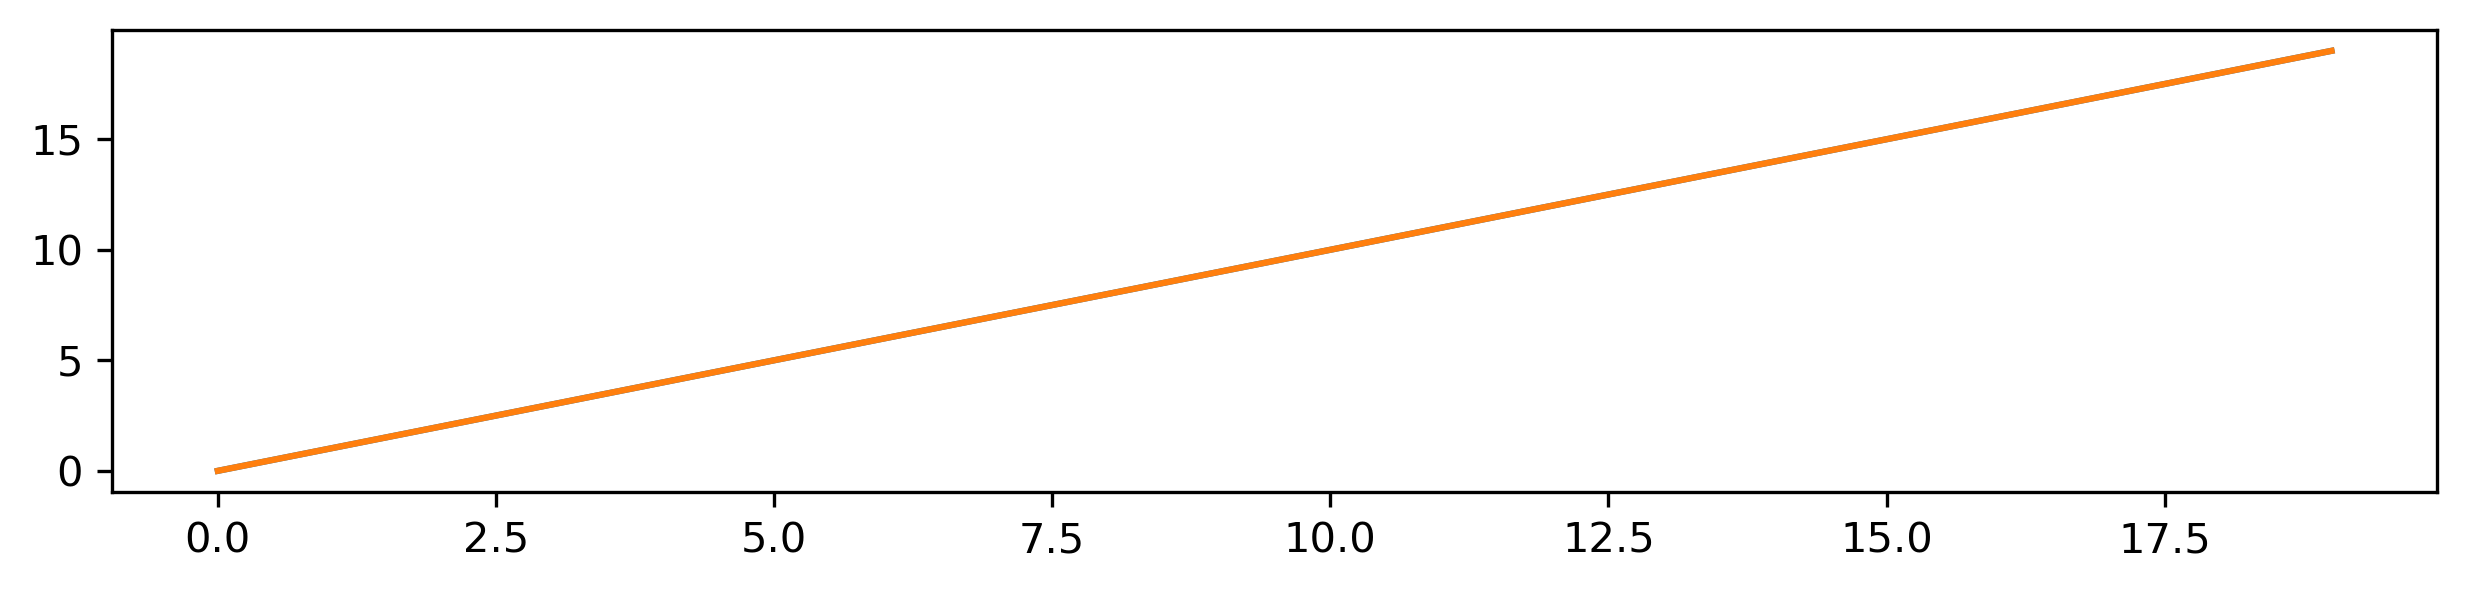

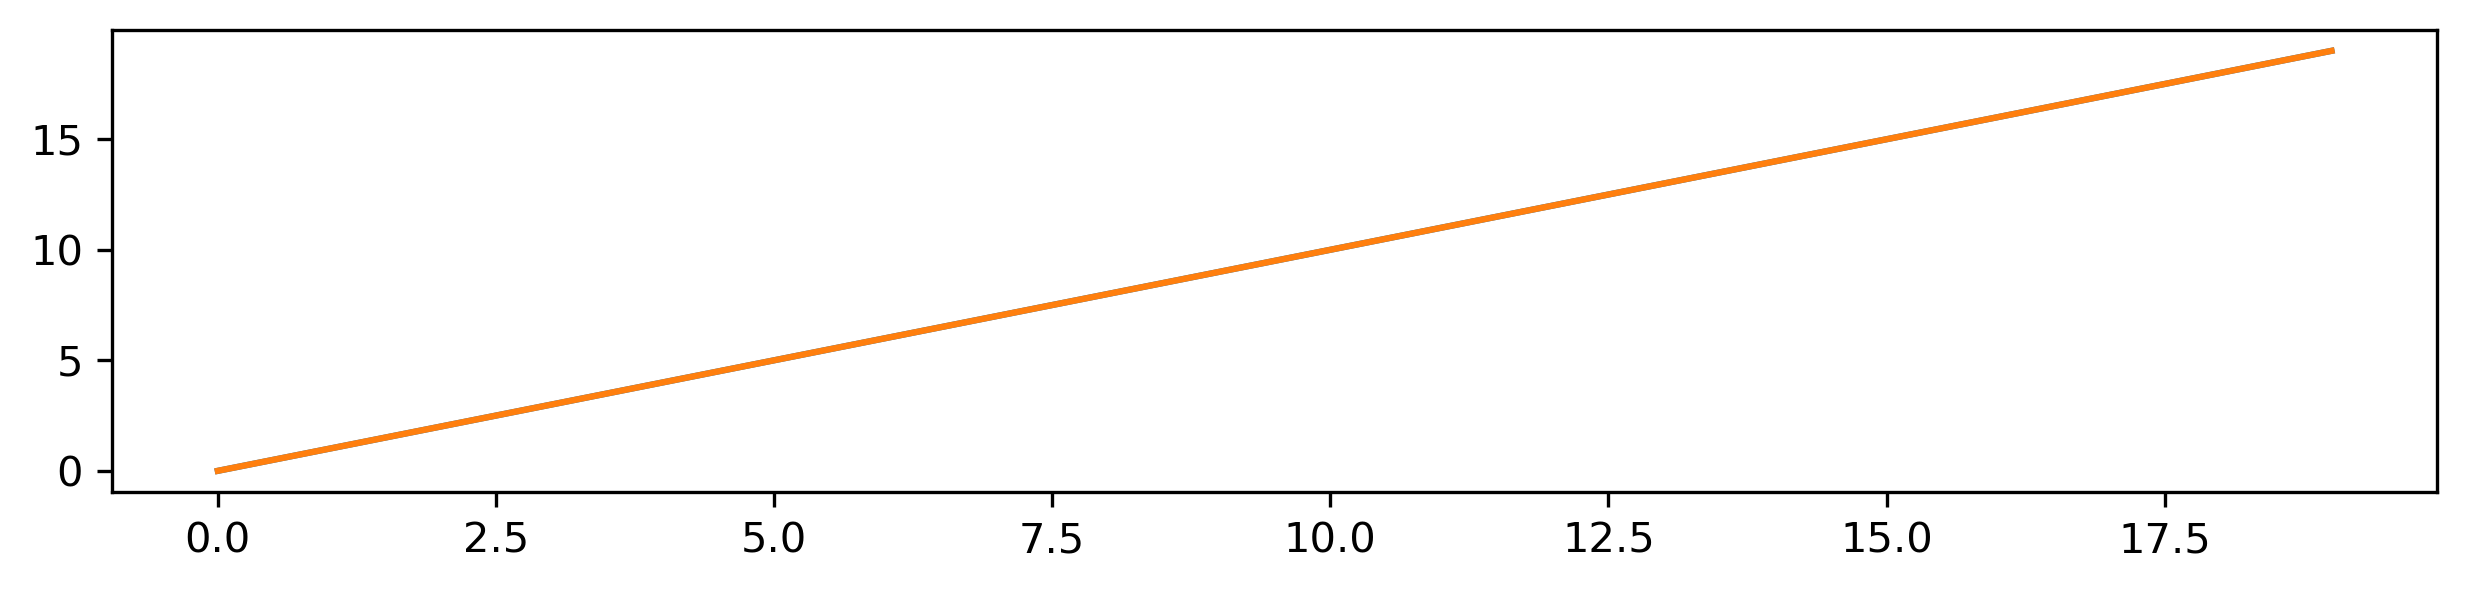

In [9]:
seriesX = np.zeros((5, 1, 20))
indexList0 = bidirect_dilation_mapping(seriesX)
indexList1 = bidirect_interleaving_mapping(seriesX)

print('Bidirectional Dilation Mapping')
print(indexList0)
print('Bidirectional Interleaving Mapping')
print(indexList1)

print("Checks whether two mappings are inverse mappings")
plt.figure(figsize=(10, 2), dpi=300)
for i in range(len(indexList0)):  # First perform dilation mapping, then interleaving mapping
    plt.plot(indexList0[i][indexList1[i]])
plt.show()

plt.figure(figsize=(10, 2), dpi=300)
for i in range(len(indexList1)):  # First perform interleaving mapping, then dilation mapping
    plt.plot(indexList1[i][indexList0[i]])
plt.show()

### (6) Bidirectional Dilation-based Statistical Feature Extraction

In [10]:
def dilated_fres_extract(seriesX, max_rate=16, basic_extractor="TSFresh"):
    """
    Extracting statistical feature vectors based on bidirectional dilation mapping 
    under multiple shuffle rates

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    max_rate : int, default=16
        Maximum shuffling rate
    basic_extractor: str, default="TSFresh"
        Basic feature extractor, options are "TSFresh" or "Catch22".
    """   

    if basic_extractor=="TSFresh":
        extractor = TSFreshFeatureExtractor(default_fc_parameters='efficient')
    elif basic_extractor=="Catch22":
        extractor = Catch22(catch24=False, replace_nans=True)
    
    indexList = bidirect_dilation_mapping(seriesX, max_rate=max_rate)  # Dilation index list
    indexList = np.vstack((np.arange(seriesX.shape[2]), indexList))  # Add the index of the raw series
    featureXList = []
    for i in range(len(indexList)):  # Perform feature extraction on each shuffled series set
        indexD_ = indexList[i]
        extractor.fit(seriesX[:, :, indexD_])
        featureX_ = np.asarray(extractor.transform(seriesX[:, :, indexD_]))
        featureXList.append(featureX_)
    featureX = np.hstack(featureXList)  # Concatenate all feature sets
    return featureX

### (7) Bidirectional Interleaving-based Statistical Feature Extraction

In [11]:
def interleaved_fres_extract(seriesX, max_rate=16, basic_extractor="TSFresh"):
    """
    Extracting statistical feature vectors based on bidirectional interleaved mapping 
    under multiple shuffle rates

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    max_rate : int, default=16
        Maximum shuffling rate
    basic_extractor: str, default="TSFresh"
        Basic feature extractor, options are "TSFresh" or "Catch22".
    """   
    
    if basic_extractor=="TSFresh":
        extractor = TSFreshFeatureExtractor(default_fc_parameters='efficient')
    elif basic_extractor=="Catch22":
        extractor = Catch22(catch24=False, replace_nans=True)
    
    indexList = bidirect_interleaving_mapping(seriesX, max_rate=max_rate)  # Interleaving index list
    featureXList = []
    for i in range(len(indexList)):  # Perform feature extraction on each shuffled series set
        indexD_ = indexList[i]
        extractor.fit(seriesX[:, :, indexD_])
        featureX_ = np.asarray(extractor.transform(seriesX[:, :, indexD_]))
        featureXList.append(featureX_)
    featureX = np.hstack(featureXList)  # Concatenate all feature sets
    return featureX

### (8) Adaptive Feature Numbers Selection

In [12]:
def adaptive_saving_features(trainX, scoresList, thresholds=[2e-05, 4e-05, 6e-05, 8e-05, 10e-05]):
    """
    Based on the stability and diversity scores of the features, the number of selected features 
    is adaptively determined through the convergence thresholds

    Parameters
    ----------
    trainX : 2D np.ndarray of shape = [n_cases, n_features] 
        Feature vector training set
    scoresList : 2D np.ndarray of shape = [n_measures, n_features] 
        List of feature scores under multiple feature measures
    thresholds: list, default=[2e-05, 4e-05, 6e-05, 8e-05, 10e-05]
        Convergence thresholds in the feature selector
    """  
    
    # Calculate stability-diversity scores
    n_cases, n_features = trainX.shape  # Number of samples and features
    n_measures = len(scoresList)  # Number of feature measures
    corrM = np.abs(np.corrcoef(trainX, rowvar=False))
    corrM[np.isnan(corrM)] = 0
    
    stabilityList = np.zeros(n_features)
    diversityList = np.zeros(n_features)
    rankList = np.zeros(n_features)
    metricList = np.zeros(n_features)
    sortIndexList = []
    rankScale = np.arange(1, n_features+1)[::-1] / n_features
    for i in range(n_measures):
        sortIndex_ = np.argsort(scoresList[i])[::-1]
        sortIndexList.append(sortIndex_)
    sortIndexList = np.array(sortIndexList)
    selfSum_ = 0
    mutualSum_ = 0
    for i in range(n_features):
        saveN = i + 1
        diversitySet_ = []
        stabilitySet_ = []
        for j in range(n_measures):
            sortIndex_ = sortIndexList[j, :saveN]
            indexlLast_ = sortIndex_[-1]
            newSubM = corrM[indexlLast_, sortIndex_]
            selfSum_ += 2*np.sum(newSubM) - 1
        diversitySet_.append(selfSum_ / (n_measures*saveN**2))
        for j in range(n_measures):
            for k in range(j+1, n_measures):
                sortIndex0_ = sortIndexList[j, :saveN]
                sortIndex1_ = sortIndexList[k, :saveN]
                indexLast0_ = sortIndex0_[-1]
                indexLast1_ = sortIndex1_[-1]
                newSubM0 = corrM[indexLast1_, sortIndex0_]
                newSubM1 = corrM[indexLast0_, sortIndex1_]
                mutualSum_ += np.sum(newSubM0) + np.sum(newSubM1) - corrM[indexLast0_, indexLast1_]
        stabilitySet_.append(mutualSum_ / ((n_measures*(n_measures-1)//2)*(saveN**2)))
        
        stabilitySet_ = np.array(stabilitySet_)
        diversityList[i] = np.mean(diversitySet_)
        stabilityList[i] = np.mean(stabilitySet_)
        metricList[i] = stabilityList[i] / diversityList[i]  # Calculate stability-diversity score    

    plt.figure(figsize=(10, 2), dpi=300)
    plt.plot(metricList, label="Stability-Diversity Scores")
    plt.legend()
    plt.show()
    
    # Determine the number of saved features
    metricList = np.abs(np.diff(metricList)/metricList[:-1])[::-1]
    kList = np.ones(len(thresholds), int)*len(metricList)

    for k in range(len(thresholds)):
        for i in range(len(metricList)):
            if metricList[i]<=thresholds[k]:
                kList[k] -= 1
            else:
                break

    print("The number of saved features", kList, len(metricList))
    return kList

### (9) Objective function of the Grey Wolf Optimizer/TD filter factor

In [13]:
def objective_function(trainSeriesX, trainY, k1=2, down_rate=4):
    """
    Objective function of the Grey Wolf Optimizer/TD filter factor

    Parameterse
    ----------
    trainSeriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        Time series training set
    trainY : list
        Labels of the training set
    k1: float, default=2
        Filter factor of tracking differentiator 
    down_rate: int, default=4
        The downsampling rate in GWO-based TD adjustment
    """  
    
    trainSeriesFX = series_transform(trainSeriesX, k1=k1)  # First-order differentiation using TD with filter factor k1
    trainSeriesFX = trainSeriesFX.reshape([trainSeriesFX.shape[0], trainSeriesFX.shape[2]])
    trainX = np.sort(trainSeriesFX, axis=1)[:, ::down_rate]  # Downsampling after sorting like QUANT
    
    score = silhouette_score(trainX, trainY)  # Calculate clustering score

    return score

### (10) A Simple Implementation of the Gray Wolf optimizer

In [14]:
def gwo(objective_function, trainSeriesX, trainY, dim=1, search_space=[1, 3], down_rate=4, num_wolves=10, max_iter=10, seed=0):
    """
    A Simple Implementation of the Gray Wolf optimizer

    Parameters
    ----------
    objective_function : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        Objective function
    trainSeriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        Time series training set
    dim: int, default=1
        Dimensions of target value
    search_space: list, default=[1, 3]
        The boundaries for the filter factor of the TD
    down_rate: int, default=4
        The downsampling rate in GWO-based TD adjustment
    num_wolves: int, default=10
        The number of wolves in GWO
    max_iter: int, default=10
        The maximum iteration in GWO
    seed: int, default=0
        Random seed
    References
    ----------
    .. [1] S. Mirjalili, S. M. Mirjalili, and A. Lewis, Grey wolf optimizer,”Adv. Eng. Softw., 
       vol. 69, pp. 46–61, Mar. 2014.
    """
    
    np.random.seed(seed)
    # Initialize the positions of the gray wolves
    wolves = np.random.uniform(low=search_space[0], high=search_space[1], size=(num_wolves, dim))

    # Record the optimal solution
    alpha_pos = np.zeros(dim)
    alpha_score = -np.inf
    alphaScoreList = np.zeros(max_iter)  # Record the scores of alpha wolves in each round

    beta_pos = np.zeros(dim)
    beta_score = -np.inf

    delta_pos = np.zeros(dim)
    delta_score = -np.inf

    # Iteratively update the positions of the wolves
    for t in range(max_iter):
        for i in range(num_wolves):
            # Calculate the objective function value of the current wolves
            fitness = objective_function(trainSeriesX, trainY, k1=wolves[i], down_rate=down_rate)
            # Update the positions of α, β, δ wolves
            if fitness > alpha_score:
                delta_pos = beta_pos.copy()
                delta_score = beta_score
                beta_pos = alpha_pos.copy()
                beta_score = alpha_score
                alpha_pos = wolves[i].copy()
                alpha_score = fitness
            elif fitness > beta_score:
                delta_pos = beta_pos.copy()
                delta_score = beta_score
                beta_pos = wolves[i].copy()
                beta_score = fitness
            elif fitness > delta_score:
                delta_pos = wolves[i].copy()
                delta_score = fitness
            alphaScoreList[t] = alpha_score  # # Record the parameters of this round of alpha wolfs

        # # Update the wolves' positions
        a = 2 - t * (2 / max_iter)  # Reduce the value of a and control the search space

        for i in range(num_wolves):
            np.random.seed(seed+i)
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)

            A = 2 * a * r1 - a
            C = 2 * r2

            D_alpha = abs(C * alpha_pos - wolves[i])  # Calculate the distance of α wolf
            D_beta = abs(C * beta_pos - wolves[i])  # Calculate the distance of β wolf
            D_delta = abs(C * delta_pos - wolves[i])  # Calculate the distance of δ wolf

            X1 = alpha_pos - A * D_alpha  # Update the wolves' positions
            X2 = beta_pos - A * D_beta
            X3 = delta_pos - A * D_delta

            wolves[i] = (X1 + X2 + X3) / 3 

            # Make sure the wolfs' positions does not exceed the search space
            wolves[i] = np.clip(wolves[i], search_space[0], search_space[1])
            
        print(f"Iteration {t+1}: Alpha k1 = {alpha_pos}", f"Alpha Score = {alpha_score}")
    
    plt.figure(figsize=(10, 3), dpi=300)
    plt.plot(alphaScoreList, label="alphaScores")
    plt.title("Alpha Score %5f"%alpha_score)
    plt.legend(loc=1)
    plt.show()    
    
    return alpha_pos, alpha_score

# 2. Mecha Class Function

In [17]:
""" MechaClassifier
    A novel and extensible feature-based TSC algorithm with ensemble structure and enhancement framework
    Multiview Enhanced Characteristics (Mecha).

"""

__maintainer__ = ["Changchun He"]
__all__ = ["MechaClassifier"]

class MechaClassifier():
    """
    Multiview Enhanced CHAracteristics (Mecha) for Time Series Classification.

    Parameters
    ----------
    basic_extractor : str, default="TSFresh"
        Basic feature extractor, options are "TSFresh" or "Catch22".
    search_space : list, default=[1.0, 3.0]
        The boundaries for the filter factor of the TD
    down_rate : int, default=4
        The downsampling rate in GWO-based TD adjustment
    num_wolves : int, default=10
        The number of wolves in GWO
    max_iter : int, default=10
        The maximum iteration in GWO
    max_rate : int, default=16
        Maximum shuffling rate
    thresholds : list, default=[2e-05, 4e-05, 6e-05, 8e-05, 10e-05]
        Convergence thresholds in the feature selector
    n_trees : int, default=200
        The number of trees in ExtraTrees 
    random_state: int, default=None
        Controls randomness
    
    
    References
    ----------
    .. [1] Changchun He, Xin Huo, Baohan Mi, and Songlin Chen. "Mecha: Multiview Enhanced Characteristics 
       via Series Shuffling  for Time Series Classification and Its Application to Turntable circuit", 
       IEEE Transactions on Circuits and Systems I: Regular Papers, 2025.
    """
    
    def __init__(
        self,
        basic_extractor="TSFresh",
        search_space=[1.0, 3.0],
        down_rate=4,
        num_wolves=10,
        max_iter=10,
        max_rate=16,
        thresholds=[2e-05, 4e-05, 6e-05, 8e-05, 10e-05],
        n_trees=200,
        random_state=0
    ):
        self.basic_extractor = basic_extractor
        self.search_space = search_space
        self.down_rate = down_rate
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        self.max_rate = max_rate
        self.thresholds = thresholds
        self.n_trees = n_trees
        self.random_state=random_state

        
    def fit(self, trainSeriesX, trainY):
        """Fit a pipeline on cases (trainSeriesX, trainY), where trainY is the target variable.

        Parameters
        ----------
        trainSeriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints]
            The training data.
        trainY : array-like, shape = [n_cases]
            The class labels. Each type of label is int.

        Returns
        -------
        self :
            Reference to self.
        """
        
        # Sereis transformation
        # Adaptively adjust the TD's filter factor through the GWO-Based TD Adjustment algorithm
        self.optimized_k1, self.optimized_score = gwo(objective_function, trainSeriesX, trainY, 
                                            search_space=self.search_space, down_rate=self.down_rate, 
                                            num_wolves=self.num_wolves, max_iter=self.max_iter,
                                            seed=self.random_state)
        trainSeriesFX = series_transform(trainSeriesX, k1=self.optimized_k1)  # First-order differential

        
        # Feature extraction
        # Bidirectional dilation feature extraction
        trainRX_Drie = dilated_fres_extract(trainSeriesX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 原始序列集特征提取
        trainFX_Drie = dilated_fres_extract(trainSeriesFX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 微分序列集特征提取
        # Bidirectional interleaving feature extraction
        trainRX_Inve = interleaved_fres_extract(trainSeriesX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 原始序列集特征提取
        trainFX_Inve = interleaved_fres_extract(trainSeriesFX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 微分序列集特征提取
        trainX = np.hstack((trainRX_Drie, trainRX_Inve, trainFX_Drie, trainFX_Inve))  # Concatenate feature sets
        trainRX_Drie, trainRX_Inve, trainFX_Drie, trainFX_Inve = 0, 0, 0, 0  # Release memory 
        # Feature normalization
        self.scaler = MinMaxScaler()
        self.scaler.fit(trainX)
        trainX = self.scaler.transform(trainX)
        
        
        # Feature selection
        # Calculate the feature scores
        scoreList = []
        scoreMI = mutual_info_classif(trainX, trainY, random_state=self.random_state)  # Mutual information
        scoreMI[np.isnan(scoreMI)] = 0   
        scoreMI[np.isinf(scoreMI)] = 0
        scoreList.append(scoreMI)

        scoreFV = f_classif(trainX, trainY)[0]  # F-statistic
        scoreFV[np.isnan(scoreFV)] = 0  
        scoreFV[np.isinf(scoreFV)] = 0
        scoreList.append(scoreFV)

        plt.figure(figsize=(10, 2), dpi=250)
        plt.plot(np.sort(scoreMI), label="Mutual Information")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 2), dpi=250)
        plt.plot(np.sort(scoreFV), label="F-statistic")
        plt.legend()
        plt.show()
        
        # Adaptive Feature Numbers Selection
        kList = adaptive_saving_features(trainX, scoreList, self.thresholds)

        self.indexListMI = []
        self.indexListFV = []
        self.indexListA = []
        for i in range(len(kList)):
            bestN = kList[i]
            if bestN<100:  # Ensure that each view has at least 100 features
                bestN = 100
            indexMI = np.argsort(scoreList[0])[::-1][:bestN]
            indexFV = np.argsort(scoreList[1])[::-1][:bestN]
            indexA = np.intersect1d(indexMI, indexFV)  # Intersection
            if len(indexA)==0:  # Avoid empty sets
                indexA = np.hstack((indexMI[:bestN//2], indexFV[:bestN//2]))
            self.indexListMI.append(indexMI) 
            self.indexListFV.append(indexFV)
            self.indexListA.append(indexA)
        

        # Classification
        self.clfListRidgeMI, self.clfListExtraMI = [], []
        self.clfListRidgeFV, self.clfListExtraFV = [], []
        self.clfListRidgeA, self.clfListExtraA = [], []
        
        for i in range(len(self.indexListMI)):
            # Classifier training under the mutual information views
            bestIndex_ = self.indexListMI[i]
            clf_ridge_mi = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
            clf_extra_mi = ExtraTreesClassifier(n_estimators=self.n_trees, random_state=self.random_state)
            clf_ridge_mi.fit(trainX[:, bestIndex_], trainY)
            clf_extra_mi.fit(trainX[:, bestIndex_], trainY)
            self.clfListRidgeMI.append(clf_ridge_mi)
            self.clfListExtraMI.append(clf_extra_mi)

            # Classifier training under the F-statistic views
            bestIndex_ = self.indexListFV[i]
            clf_ridge_fv = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True) 
            clf_extra_fv = ExtraTreesClassifier(n_estimators=self.n_trees, random_state=self.random_state)
            clf_ridge_fv.fit(trainX[:, bestIndex_], trainY)  
            clf_extra_fv.fit(trainX[:, bestIndex_], trainY)  
            self.clfListRidgeFV.append(clf_ridge_fv) 
            self.clfListExtraFV.append(clf_extra_fv)

            # Classifier training under the intersection views
            bestIndex_ = self.indexListA[i]
            clf_ridge_a = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
            clf_extra_a = ExtraTreesClassifier(n_estimators=self.n_trees, random_state=self.random_state)
            clf_ridge_a.fit(trainX[:, bestIndex_], trainY)  
            clf_extra_a.fit(trainX[:, bestIndex_], trainY) 
            self.clfListRidgeA.append(clf_ridge_a)
            self.clfListExtraA.append(clf_extra_a)
    
        
    def predict(self, testSeriesX):
        """Predict class values of n instances in testSeriesX.

        Parameters
        ----------
        testSignalX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints]
            The data to make predictions for testSignalX.

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        
        # Sereis transformation
        testSeriesFX = series_transform(testSeriesX, k1=self.optimized_k1)  # First-order differential

        
        # Feature extraction
        # Bidirectional dilation feature extraction
        testRX_Drie = dilated_fres_extract(testSeriesX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 原始序列集特征提取
        testFX_Drie = dilated_fres_extract(testSeriesFX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 微分序列集特征提取
        # Bidirectional interleaving feature extraction
        testRX_Inve = interleaved_fres_extract(testSeriesX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 原始序列集特征提取
        testFX_Inve = interleaved_fres_extract(testSeriesFX, max_rate=self.max_rate, basic_extractor=self.basic_extractor)  # 微分序列集特征提取
        testX = np.hstack((testRX_Drie, testRX_Inve, testFX_Drie, testFX_Inve))  # Concatenate feature sets
        testRX_Drie, testRX_Inve, testFX_Drie, testFX_Inve = 0, 0, 0, 0  # Release memory 
        # Feature normalization
        testX = self.scaler.transform(testX)
        
        
        # Classification
        testPYListMI_RL, testPYListFV_RL, testPYListA_RL = [], [], []
        testPYListMI_ET, testPYListFV_ET, testPYListA_ET = [], [], []

        for i in range(len(self.indexListMI)):
            # Prediction under the mutual information views
            bestIndex_ = self.indexListMI[i]  
            clf_ridge_mi = self.clfListRidgeMI[i]  
            clf_extra_mi = self.clfListExtraMI[i]  
            testPY_Doub0 = clf_ridge_mi.predict(testX[:, bestIndex_])
            testPY_Doub1 = clf_extra_mi.predict(testX[:, bestIndex_])
            testPYListMI_RL.append(testPY_Doub0)  
            testPYListMI_ET.append(testPY_Doub1)

            # Prediction under the F-statistic views
            bestIndex_ = self.indexListFV[i] 
            clf_ridge_fv = self.clfListRidgeFV[i]  
            clf_extra_fv = self.clfListExtraFV[i]  
            testPY_Doub0 = clf_ridge_fv.predict(testX[:, bestIndex_])
            testPY_Doub1 = clf_extra_fv.predict(testX[:, bestIndex_])
            testPYListFV_RL.append(testPY_Doub0)  
            testPYListFV_ET.append(testPY_Doub1)  

            # Prediction under the intersection views
            bestIndex_ = self.indexListA[i] 
            clf_ridge_a = self.clfListRidgeA[i]  
            clf_extra_a = self.clfListExtraA[i] 
            testPY_Doub0 = clf_ridge_a.predict(testX[:, bestIndex_])
            testPY_Doub1 = clf_extra_a.predict(testX[:, bestIndex_])
            testPYListA_RL.append(testPY_Doub0) 
            testPYListA_ET.append(testPY_Doub1) 
            
        testPYListMI_RL = np.array(testPYListMI_RL)
        testPYListFV_RL = np.array(testPYListFV_RL)
        testPYListA_RL = np.array(testPYListA_RL)
        testPYListMI_ET = np.array(testPYListMI_ET)
        testPYListFV_ET = np.array(testPYListFV_ET)
        testPYListA_ET = np.array(testPYListA_ET)
        
        # Hard voting
        testPY= hard_voting(np.vstack((testPYListMI_RL, testPYListFV_RL, testPYListA_RL, 
                                       testPYListMI_ET, testPYListFV_ET, testPYListA_ET)))
        
        return testPY

## Classification Example

Iteration 1: Alpha k1 = [1.76688304] Alpha Score = 0.04622147011863708
Iteration 2: Alpha k1 = [1.53961493] Alpha Score = 0.04785368972661261
Iteration 3: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 4: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 5: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 6: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 7: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 8: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 9: Alpha k1 = [1.56014094] Alpha Score = 0.04852339517534807
Iteration 10: Alpha k1 = [1.59428634] Alpha Score = 0.04914101864530253


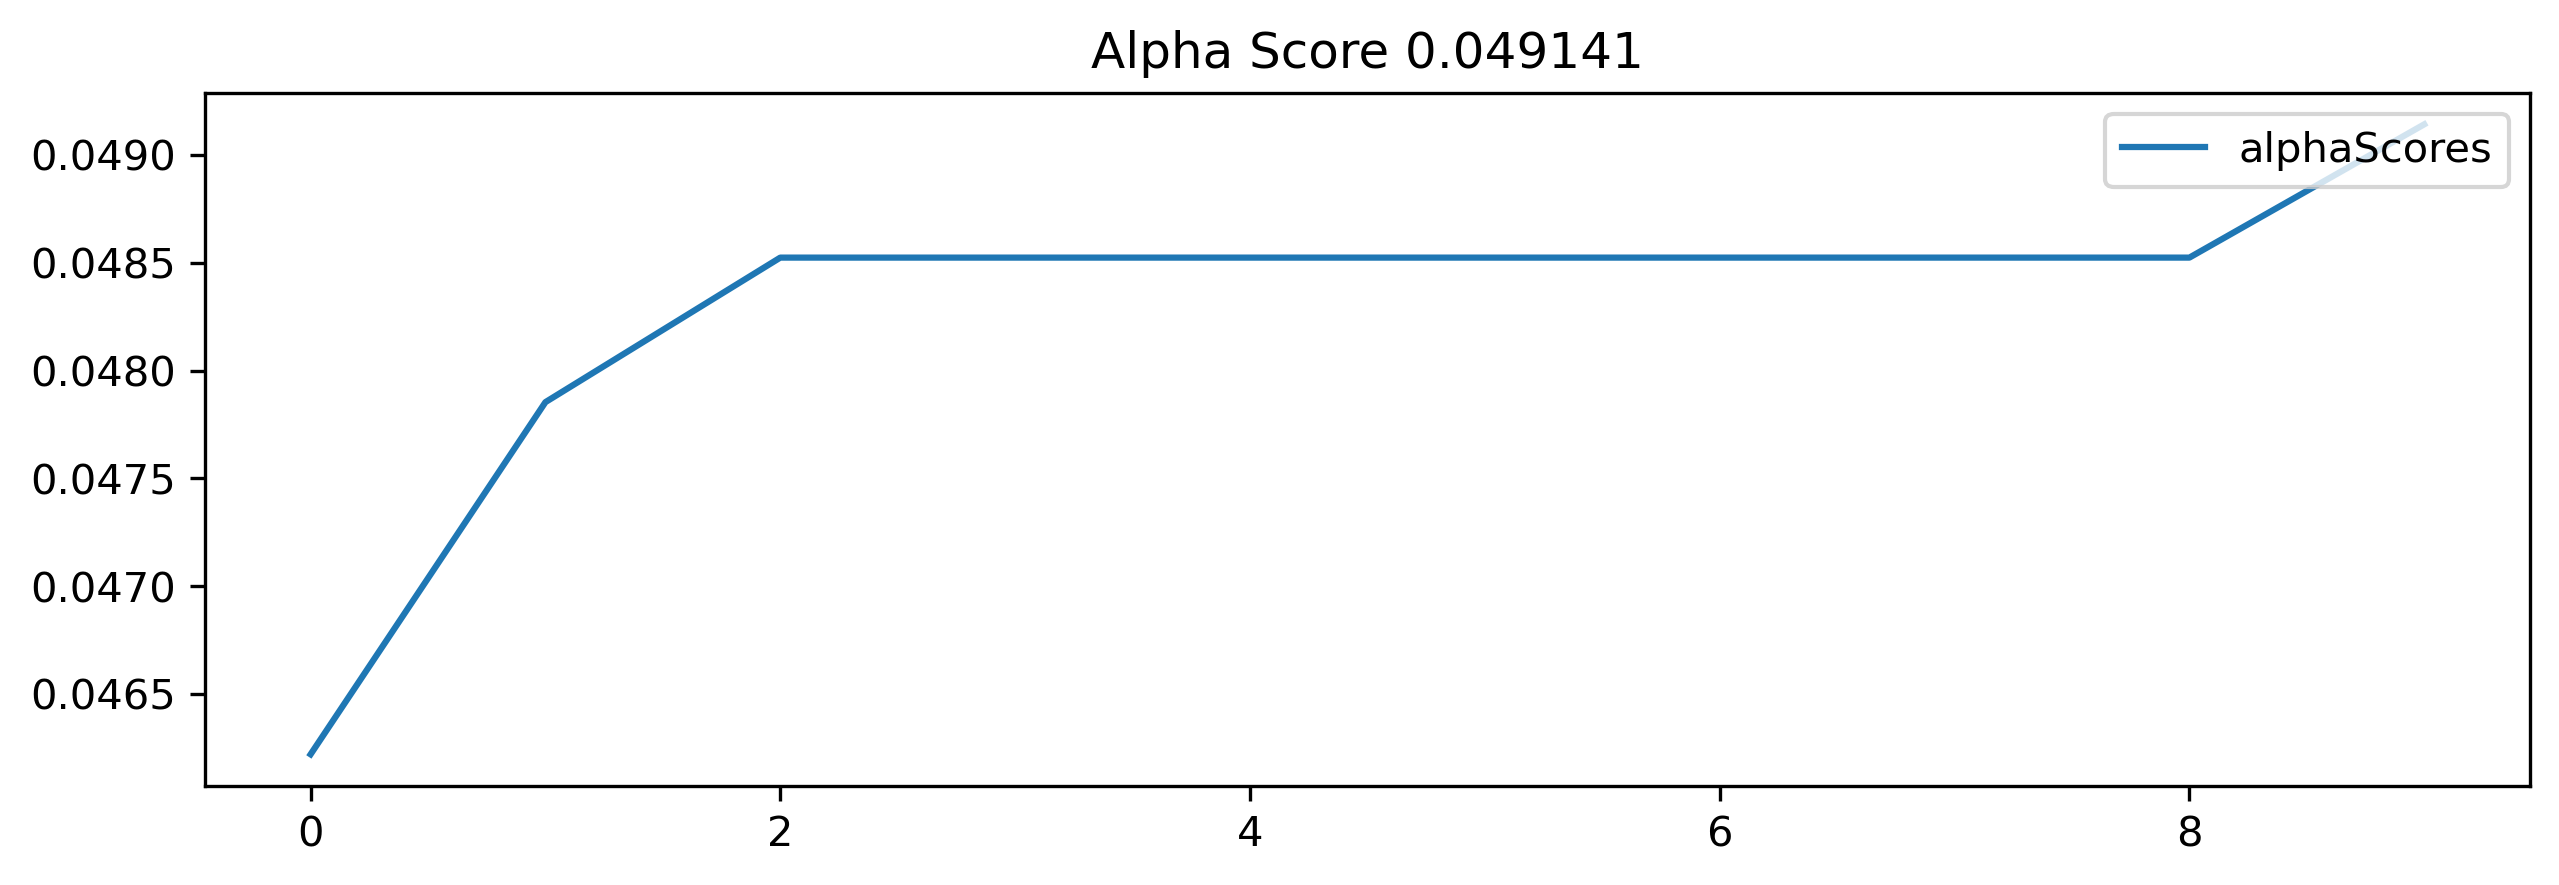

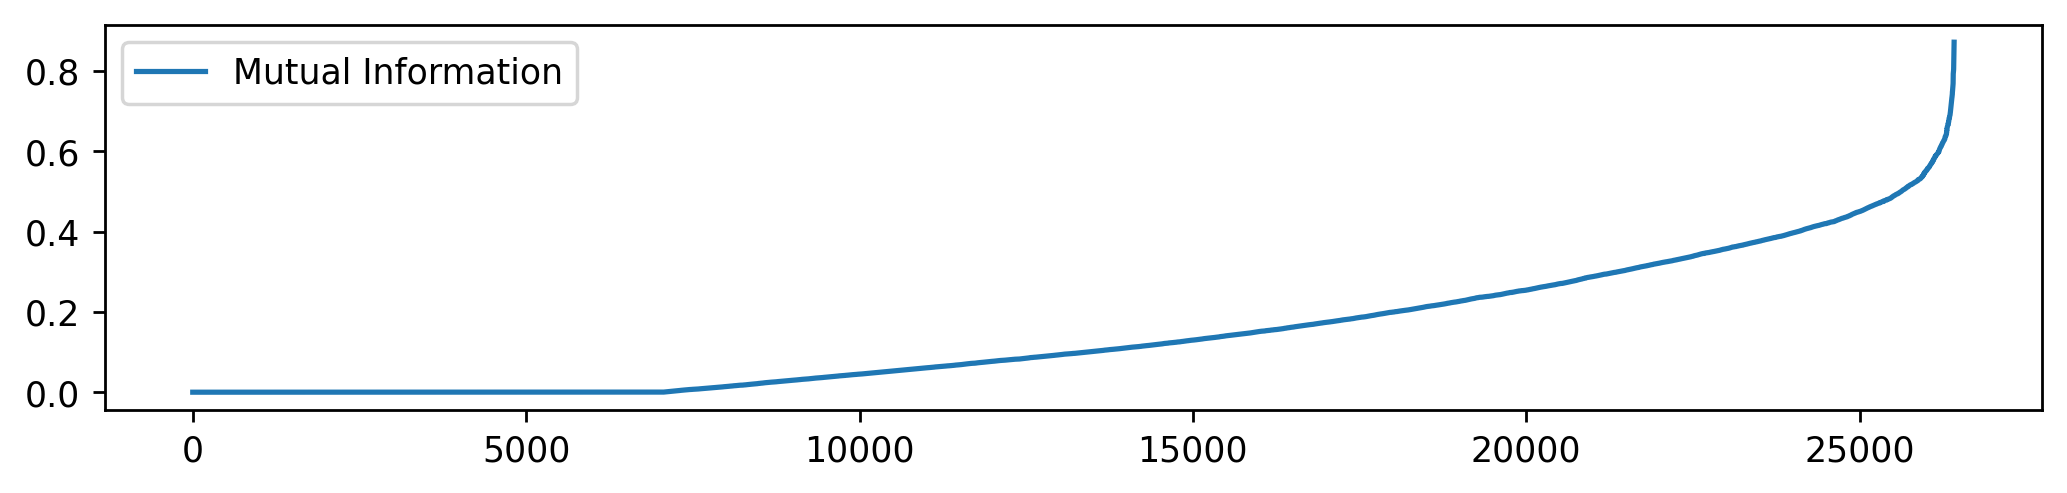

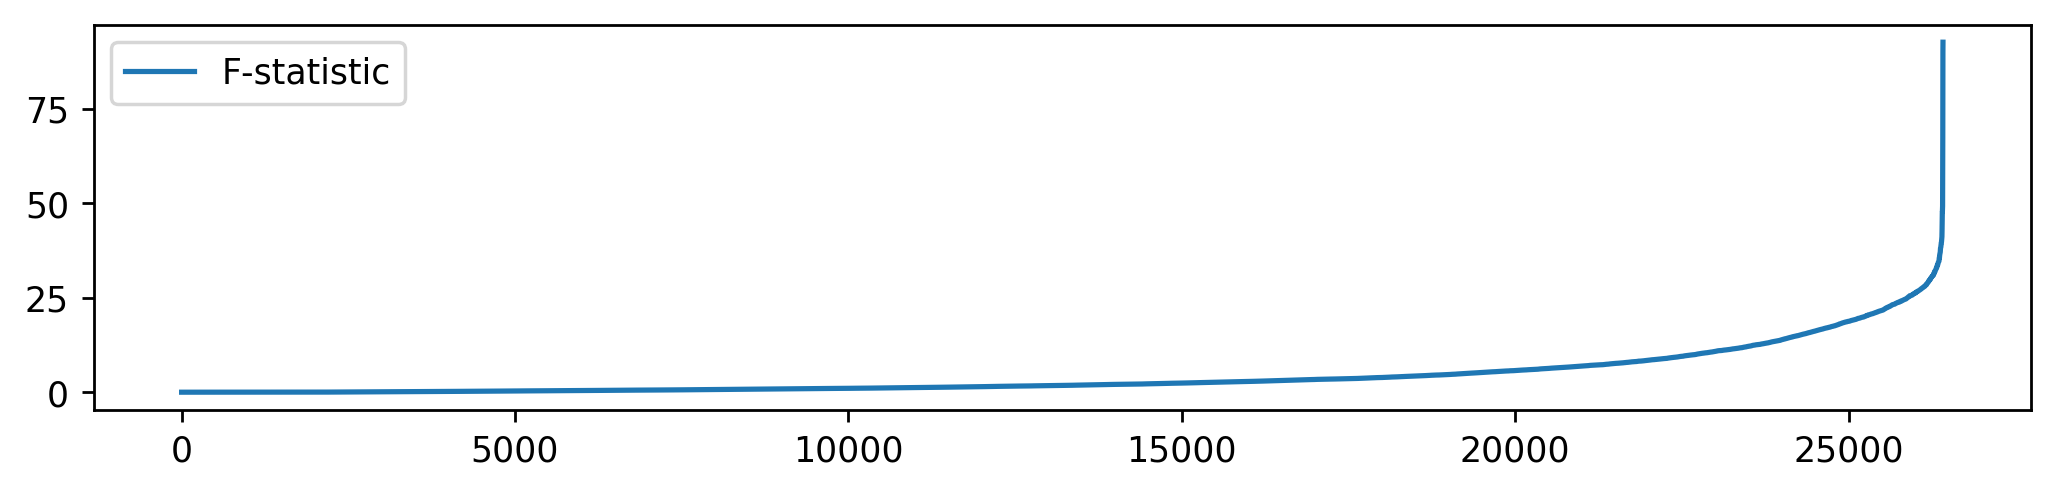

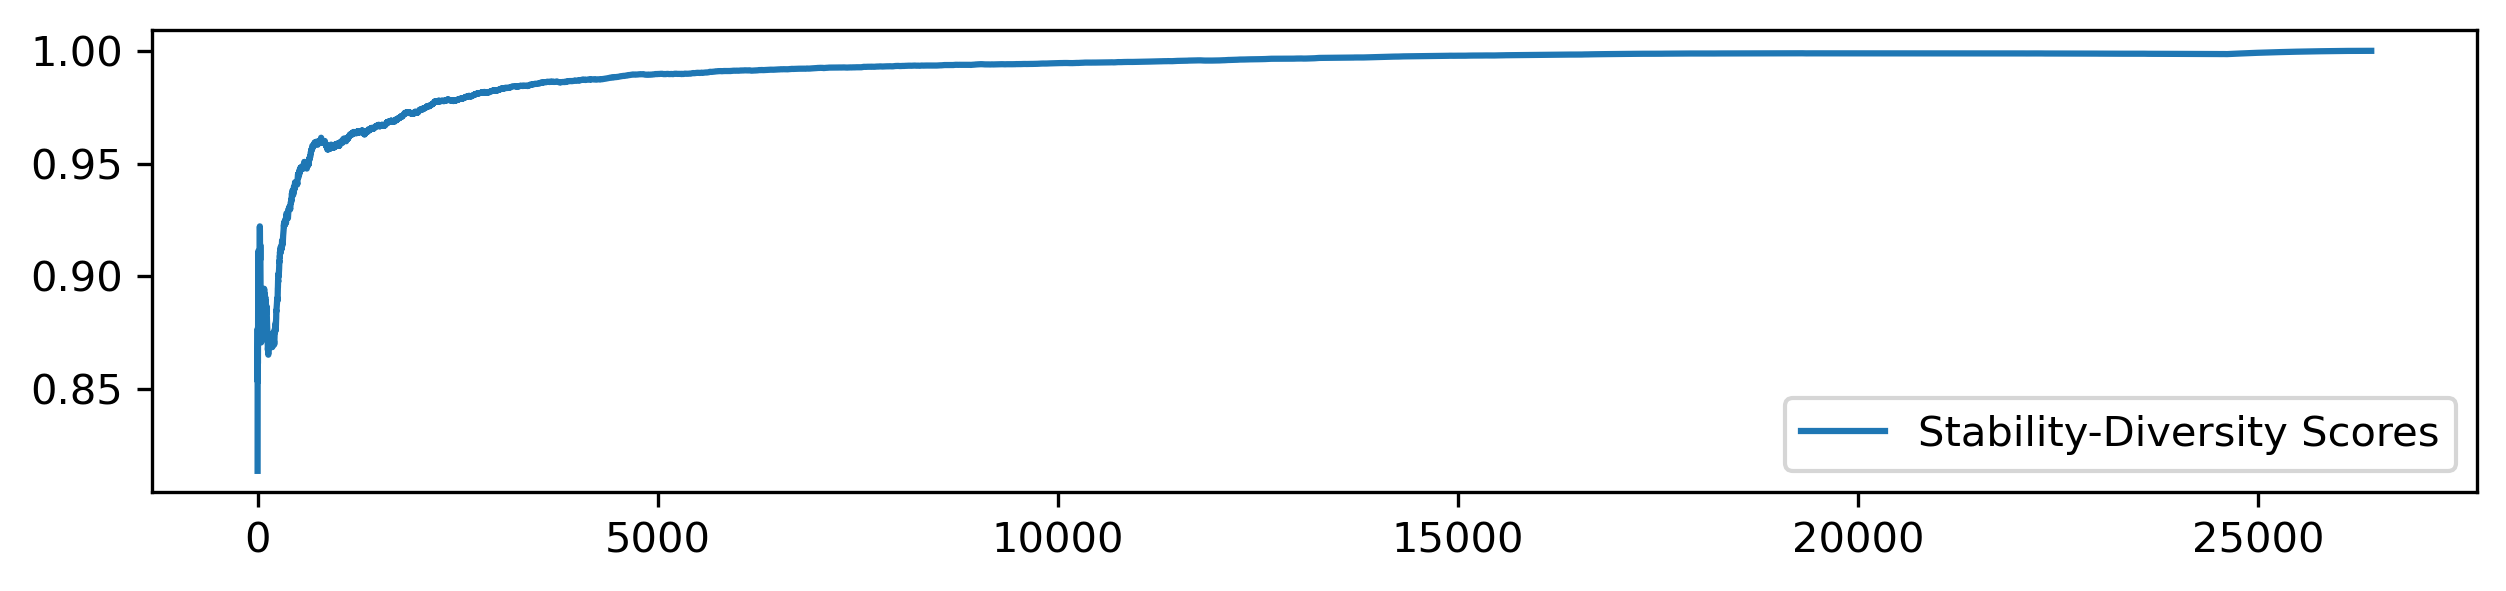

The number of saved features [7601 4434 3539 2914 2431] 26417
Accuracy : 0.8571428571428571


In [18]:
# Loading time series set
from aeon.datasets import load_arrow_head
trainSeriesX, trainY = load_arrow_head("TRAIN")
testSeriesX, testY = load_arrow_head("TEST")
# Note that the input and output labels of our classifier are in the format of int.
trainY, testY = trainY.astype(int), testY.astype(int)

# Classification
mecha = MechaClassifier(random_state=0)
mecha.fit(trainSeriesX, trainY)
testPY = mecha.predict(testSeriesX)

# Result
accV = np.sum(testPY==testY) / len(testY)
print("Accuracy :", accV)